In [1]:
import os
from zipfile import ZipFile
import matplotlib  # Used to set default paremeters
import matplotlib.gridspec as gridspec
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm  # statistical modelling package
from matplotlib import rcParams  # Used to set default paremeters
from sklearn.compose import make_column_transformer
from sklearn.linear_model import Lasso, LinearRegression, Ridge
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import (
    KFold,
    LeaveOneOut,
    cross_val_predict,
    cross_val_score,
    train_test_split,
)
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import (
    PolynomialFeatures,
    StandardScaler,
    OneHotEncoder,
    LabelEncoder,
    LabelBinarizer,
    MinMaxScaler,
)

In [2]:
sns.set_theme(style="darkgrid")

# Set Default Fonts
rcParams["font.family"] = "sans-serif"
rcParams["font.sans-serif"] = ["Arial", "Tahoma"]

# Set Default font sizes
small_size = 12
medium_size = 14
large_size = 16

# Change the font size for individual elements
matplotlib.rc("font", size=small_size)  # controls default text sizes
matplotlib.rc("axes", titlesize=small_size)  # fontsize of the axes title
matplotlib.rc("axes", labelsize=medium_size)  # fontsize of the x and y labels
matplotlib.rc("xtick", labelsize=small_size)  # fontsize of the tick labels
matplotlib.rc("ytick", labelsize=small_size)  # fontsize of the tick labels
matplotlib.rc("legend", fontsize=small_size)  # legend fontsize
matplotlib.rc("axes", titlesize=large_size)  # title fontsize


In [3]:
dataset_info = !kaggle datasets files thedevastator/uncovering-factors-that-affect-used-car-prices
dataset_name =  dataset_info[-1].split()[0]


path_data = os.getcwd() + "/data"
path_zip = os.getcwd() + "/data/uncovering-factors-that-affect-used-car-prices.zip"
path_file = os.getcwd() + "/data/" + dataset_name

# if data is already donwloaded, print a statement to remind me
if os.path.exists(path_file):
    print("Data has already been downloaded")
# otherwise, download the data
else:
    # download data using kaggle API
    !kaggle datasets download -d thedevastator/uncovering-factors-that-affect-used-car-prices -p data

    # extract files in .zip folder
    with ZipFile(path_zip) as zObject:
        zObject.extractall(path=path_data)

    # delete .zip folder
    if os.path.exists(path_zip):
        os.remove(path_zip)
    else:
        print(".zip file already deleted")

Data has already been downloaded


# EDA and Feature Engineering
## Data understanding

In [4]:
data = pd.read_csv("data/autos.csv", index_col=0)

# Only interested in German cars
data = data.loc[
    (data["brand"] == "bmw")
    | (data["brand"] == "audi")
    | (data["brand"] == "volkswagen")
    | (data["brand"] == "mercedes_benz")
    | (data["brand"] == "opel"),
    :
].reset_index(drop=True)

data.head(7)


,dateCrawled,name,seller,offerType,price,abtest,vehicleType,yearOfRegistration,gearbox,powerPS,model,kilometer,monthOfRegistration,fuelType,brand,notRepairedDamage,dateCreated,nrOfPictures,postalCode,lastSeen
0,2016-03-24 11:52:17,Golf_3_1.6,privat,Angebot,480,test,NaN,1993,manuell,0,golf,150000,0,benzin,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,A5_Sportback_2.7_Tdi,privat,Angebot,18300,test,coupe,2011,manuell,190,NaN,125000,5,diesel,audi,ja,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-17 16:54:04,GOLF_4_1_4__3TÜRER,privat,Angebot,1500,test,kleinwagen,2001,manuell,75,golf,150000,6,benzin,volkswagen,nein,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
3,2016-04-04 17:36:23,BMW_316i___e36_Limousine___Bastlerfahrzeug__Ex...,privat,Angebot,650,test,limousine,1995,manuell,102,3er,150000,10,benzin,bmw,ja,2016-04-04 00:00:00,0,33775,2016-04-06 19:17:07
4,2016-03-21 18:54:38,VW_Derby_Bj_80__Scheunenfund,privat,Angebot,0,test,limousine,1980,manuell,50,andere,40000,7,benzin,volkswagen,nein,2016-03-21 00:00:00,0,19348,2016-03-25 16:47:58
5,2016-03-17 10:53:50,VW_Golf_4_5_tuerig_zu_verkaufen_mit_Anhaengerk...,privat,Angebot,999,test,kleinwagen,1998,manuell,101,golf,150000,0,NaN,volkswagen,NaN,2016-03-17 00:00:00,0,27472,2016-03-31 17:17:06
6,2016-04-07 10:06:22,Volkswagen_Passat_Variant_2.0_TDI_Comfortline,privat,Angebot,2799,control,kombi,2005,manuell,140,passat,150000,12,diesel,volkswagen,ja,2016-04-07 00:00:00,0,57290,2016-04-07 10:25:17


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 228232 entries, 0 to 228231
Data columns (total 20 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   dateCrawled          228232 non-null  object
 1   name                 228232 non-null  object
 2   seller               228232 non-null  object
 3   offerType            228232 non-null  object
 4   price                228232 non-null  int64 
 5   abtest               228232 non-null  object
 6   vehicleType          205606 non-null  object
 7   yearOfRegistration   228232 non-null  int64 
 8   gearbox              216993 non-null  object
 9   powerPS              228232 non-null  int64 
 10  model                218291 non-null  object
 11  kilometer            228232 non-null  int64 
 12  monthOfRegistration  228232 non-null  int64 
 13  fuelType             208642 non-null  object
 14  brand                228232 non-null  object
 15  notRepairedDamage    184016 non-nu

In [6]:
data.describe()

,price,yearOfRegistration,powerPS,kilometer,monthOfRegistration,nrOfPictures,postalCode
count,2.282320e+05,228232.000000,228232.000000,228232.000000,228232.000000,228232.0,228232.000000
mean,1.321101e+04,2004.057389,125.857220,129860.339479,5.789679,0.0,51318.138876
std,7.648302e+05,78.503991,203.981543,37742.381405,3.724106,0.0,25911.301362
min,0.000000e+00,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1.300000e+03,1999.000000,75.000000,125000.000000,3.000000,0.0,30880.000000
50%,3.450000e+03,2003.000000,116.000000,150000.000000,6.000000,0.0,49744.000000
75%,8.450000e+03,2008.000000,163.000000,150000.000000,9.000000,0.0,72488.000000
max,1.000000e+08,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


## Data preparation

The first step in the data preparation process is to remove duplicates

In [7]:
data.duplicated(
    subset=[
        "name",
        "price",
        "yearOfRegistration",
        "gearbox",
        "kilometer",
        "fuelType",
        "monthOfRegistration",
        "dateCreated",
        "postalCode",
        "lastSeen",
    ],
).value_counts()

False    228208
True         24
dtype: int64

In [8]:

data.drop_duplicates(
    subset=[
        "name",
        "price",
        "yearOfRegistration",
        "gearbox",
        "kilometer",
        "fuelType",
        "monthOfRegistration",
        "dateCreated",
        "postalCode",
        "lastSeen",
    ],
    ignore_index=True,
    inplace=True
)

The next step is to drop irrelevant features. I will first capture the year when the data was added. In the future, I would like to add more datapoints and it would be great to keep track of the year when they were all added.

In [9]:
data["yearCreated"] = pd.to_datetime(data["dateCreated"]).dt.year

data.drop(
    [
        "name",
        "seller",
        "offerType",
        "dateCrawled",
        "abtest",
        "dateCreated",
        "notRepairedDamage",
        "nrOfPictures",
        "postalCode",
        "lastSeen",
        "monthOfRegistration",
        "yearCreated"
    ],
    axis=1,
    inplace=True,
)

data.head()

,price,vehicleType,yearOfRegistration,gearbox,powerPS,model,kilometer,fuelType,brand
0,480,NaN,1993,manuell,0,golf,150000,benzin,volkswagen
1,18300,coupe,2011,manuell,190,NaN,125000,diesel,audi
2,1500,kleinwagen,2001,manuell,75,golf,150000,benzin,volkswagen
3,650,limousine,1995,manuell,102,3er,150000,benzin,bmw
4,0,limousine,1980,manuell,50,andere,40000,benzin,volkswagen


After removing duplicates, we need to deal with `NaN` values.

In [10]:
data.isna().sum()

price                     0
vehicleType           22626
yearOfRegistration        0
gearbox               11239
powerPS                   0
model                  9941
kilometer                 0
fuelType              19590
brand                     0
dtype: int64

In [11]:
data.dropna(axis=0, subset=["gearbox", "fuelType"], inplace=True)
data.reset_index(drop=True, inplace=True)
data.isna().sum()

price                     0
vehicleType           10621
yearOfRegistration        0
gearbox                   0
powerPS                   0
model                  5510
kilometer                 0
fuelType                  0
brand                     0
dtype: int64

Since the dataset contains some German words, I will replace them using the equivalent English words.

In [12]:
data["gearbox"].replace({"manuell": "Manual", "automatik": "Automatic"}, inplace=True)
data["fuelType"].replace({"benzin": "Petrol", "diesel": "Diesel"}, inplace=True)
data["model"].replace({"andere": "unknown"}, inplace=True)
data["vehicleType"].replace({"andere": "unknown"}, inplace=True)

Some of the columns include the word "andere", whiche means "unknown" in English. In the next sections I will perform feature engineering and create new features based on the car model. Therefore, unknown car models need to removed.

In [13]:

data = data[data["model"] != "unknown"].reset_index(drop=True)

In [14]:
data = data.loc[
    (data["fuelType"] == "Petrol") | (data["fuelType"] == "Diesel"), :
].reset_index(drop=True)

### Feature Engineering

In [15]:
data["powerHP"] = data["powerPS"] * 0.98632
data.drop(columns=["powerPS"], inplace=True)

In [16]:
data.head()

,price,vehicleType,yearOfRegistration,gearbox,model,kilometer,fuelType,brand,powerHP
0,480,NaN,1993,Manual,golf,150000,Petrol,volkswagen,0.00000
1,18300,coupe,2011,Manual,NaN,125000,Diesel,audi,187.40080
2,1500,kleinwagen,2001,Manual,golf,150000,Petrol,volkswagen,73.97400
3,650,limousine,1995,Manual,3er,150000,Petrol,bmw,100.60464
4,2799,kombi,2005,Manual,passat,150000,Diesel,volkswagen,138.08480


In [17]:
transformer = make_column_transformer(
    (OneHotEncoder(drop="first"), ["gearbox", "fuelType"]),
    remainder="drop",
)

transformed = transformer.fit_transform(data)
data_transformed = pd.DataFrame(
    transformed, columns=transformer.get_feature_names_out()
)

data["gearbox"] = data_transformed["onehotencoder__gearbox_Manual"]
data["fuelType"] = data_transformed["onehotencoder__fuelType_Petrol"]

data["gearbox"] = data["gearbox"].astype(int)
data["fuelType"] = data["fuelType"].astype(int)

## Feature understanding and outliers

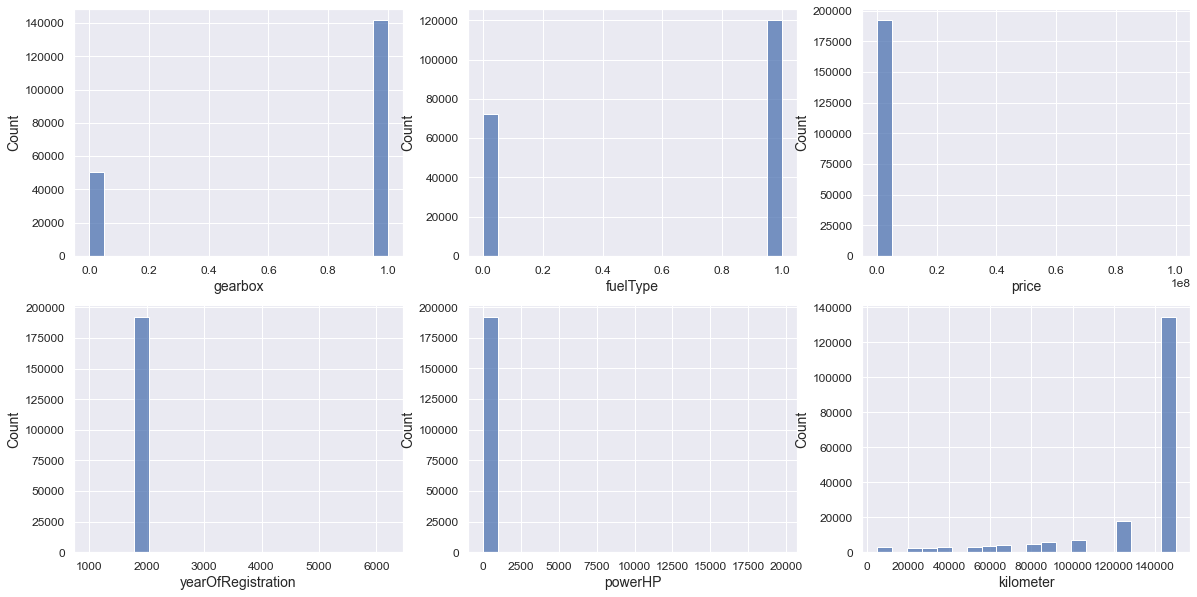

In [18]:
hist_features = [
    "gearbox",
    "fuelType",
    "price",
    "yearOfRegistration",
    "powerHP",
    "kilometer",
]

fig, axes = plt.subplots(2, 3, figsize=(20, 10))
axes = axes.flatten()

for i, feature in enumerate(hist_features):
    sns.histplot(x=data[feature], data=data, ax=axes[i], bins=20)

### Price


In [19]:
data = data[(data["price"] > 300) & (data["price"] < 100000)].reset_index(drop=True)

<AxesSubplot:xlabel='price', ylabel='brand'>

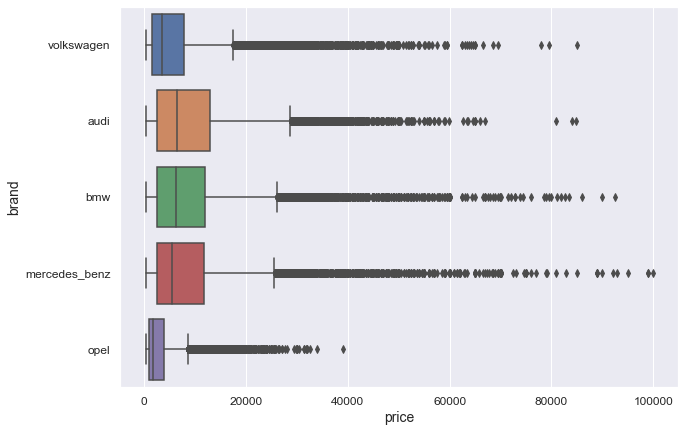

In [20]:
fig, ax = plt.subplots(figsize=(10,7))

sns.boxplot(x="price", y="brand", data=data, ax=ax)

### Power

In [21]:
mask_opel = ((data["powerHP"] < 40) | (data["powerHP"] > 250)) & (
    data["brand"] == "opel"
)
mask_volks = ((data["powerHP"] < 40) | (data["powerHP"] > 250)) & (
    data["brand"] == "volkswagen"
)
mask_audi = ((data["powerHP"] < 40) | (data["powerHP"] > 250)) & (
    data["brand"] == "audi"
)
mask_mercedes = ((data["powerHP"] < 40) | (data["powerHP"] > 250)) & (
    data["brand"] == "mercedes_benz"
)
mask_bmw = ((data["powerHP"] < 40) | (data["powerHP"] > 250)) & (data["brand"] == "bmw")
mask = mask_opel | mask_volks | mask_audi | mask_mercedes | mask_bmw

data = data[~mask].reset_index(drop=True)

<AxesSubplot:xlabel='powerHP', ylabel='brand'>

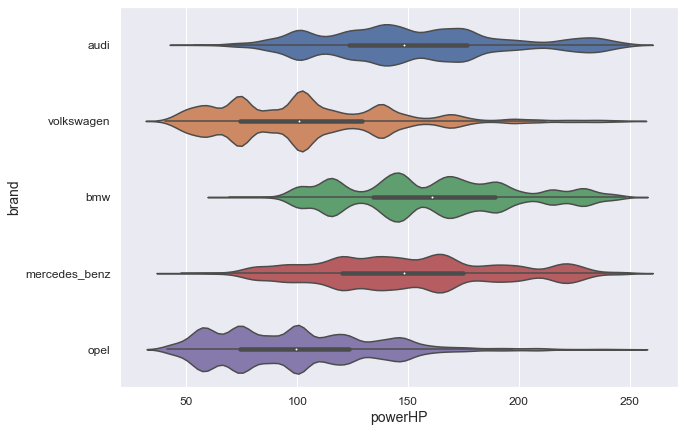

In [22]:
fig, ax = plt.subplots(figsize=(10,7))

sns.violinplot(x="powerHP", y="brand", data=data, ax=ax)

### Year of registration

In [23]:
data.loc[
    (data["yearOfRegistration"] > 1970) & (data["yearOfRegistration"] < 1985),
    "yearOfRegistration",
].value_counts().to_frame()

,yearOfRegistration
1983,145
1984,134
1982,109
1979,84
1978,79
1981,69
1980,68
1974,42
1973,41
1977,37


In [24]:
data = data[
    (data["yearOfRegistration"] > 1978) & (data["yearOfRegistration"] < 2016)
].reset_index(drop=True)

<AxesSubplot:xlabel='yearOfRegistration', ylabel='brand'>

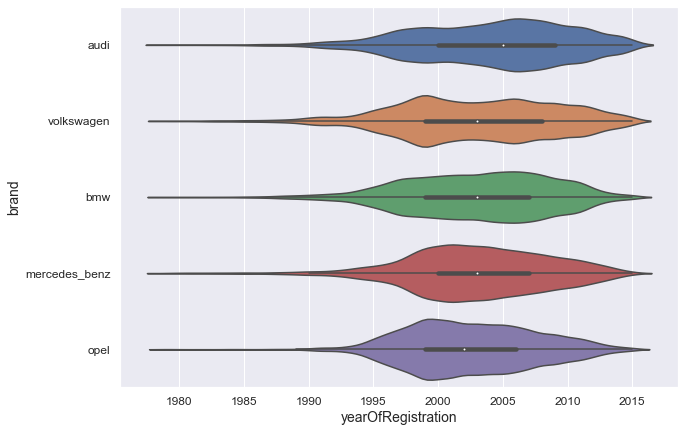

In [25]:
# fig, axes = plt.subplots(1,2,figsize=(16,5))

# sns.histplot(x="yearOfRegistration", data=test, bins=45, ax=axes[0], hue="brand")

# sns.histplot(x="yearOfRegistration", data=test, bins=45, ax=axes[1], hue="brand", multiple="stack")
# axes[1].set_ylim(0, 200)

fig, ax = plt.subplots(figsize=(10,7))

# sns.histplot(x="yearOfRegistration", hue="brand", data=data, ax=ax, multiple="stack")
sns.violinplot(x="yearOfRegistration", y="brand", data=data, ax=ax)

## Feature Relationships

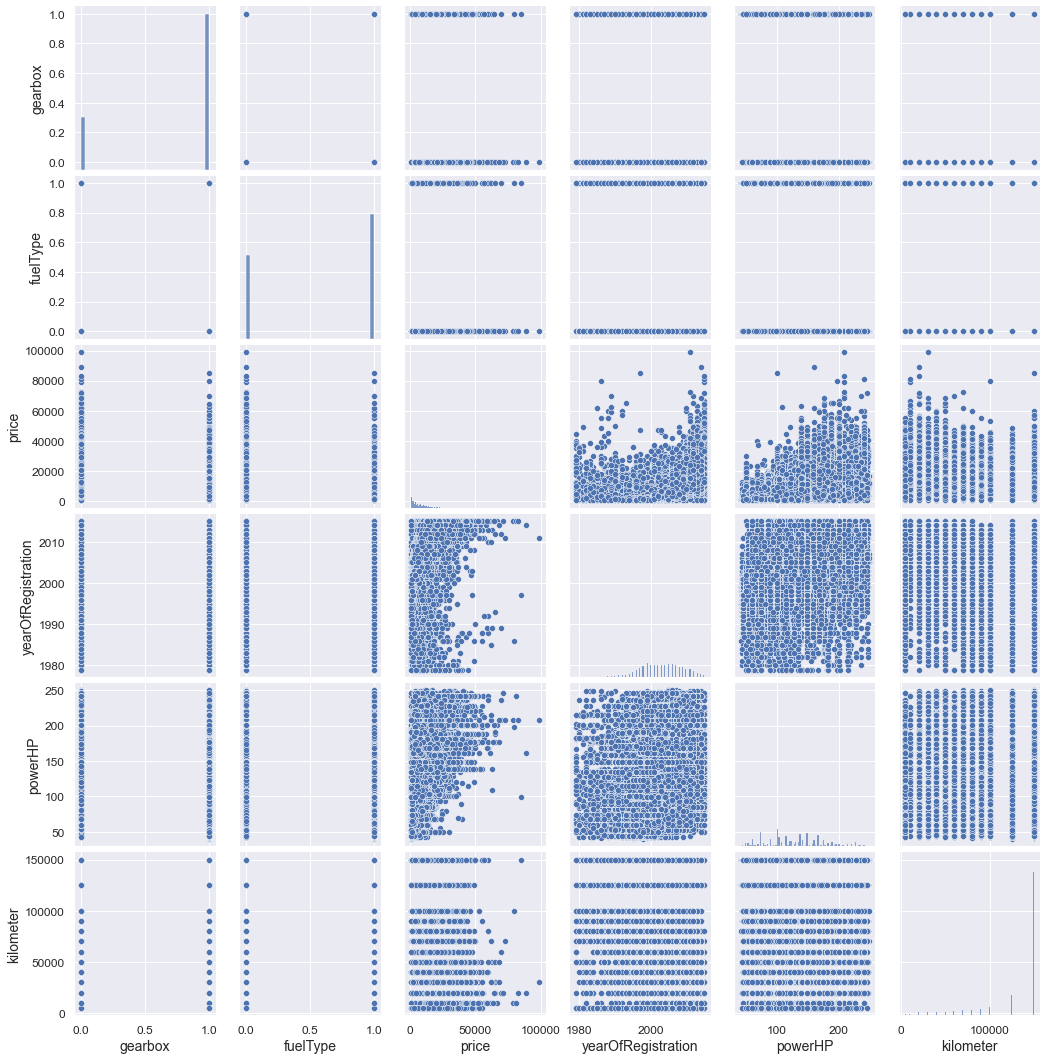

In [26]:
pairplot_features = hist_features.copy()
pairplot_features.append("brand")
sns.pairplot(data=data[pairplot_features])

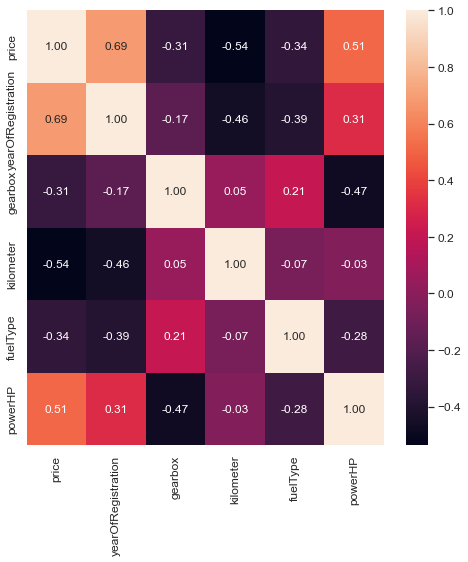

In [27]:
plt.figure(figsize=(8, 8))
sns.heatmap(data.corr(), annot=True, fmt=".2f");


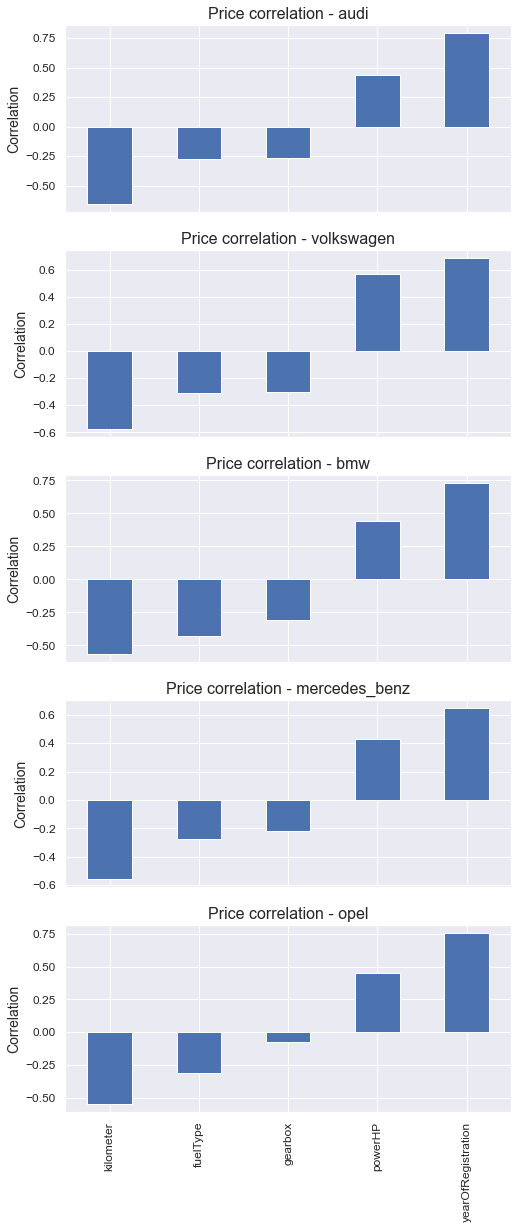

In [28]:
brands = data["brand"].unique().tolist()

fig, axes = plt.subplots(5, 1, figsize=(8, 20), sharex=True)
axes = axes.flatten()

for i, brand in enumerate(brands):
    data_brand = data[data["brand"] == brand]
    corr_df = data_brand.corr()["price"].sort_values()[:-1]
    corr_df.plot(
        kind="bar",
        ax=axes[i],
        title=f"Price correlation - {brand}",
        ylabel="Correlation",
    )

# Linear regression - No difference between brands

In [29]:
# audi_values = {
#     "100": {"engineSize": 1.8, "mpg": 37},
#     "200": {"engineSize": 2.2, "mpg": 29},
#     "80": {"engineSize": 1.8, "mpg": 28},
    

# }

# data.query("brand == 'audi'").groupby(["brand", "model"]).size().unstack()